# BackPack 🎒

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e2/sample_submission.csv
/kaggle/input/playground-series-s5e2/train.csv
/kaggle/input/playground-series-s5e2/test.csv
/kaggle/input/playground-series-s5e2/training_extra.csv


# Table of Contents

<ol>
    <li><a href='https://www.kaggle.com/code/cmdhmn/backpack/edit/run/220837091#Data-Analysis' target="_self">Data Analysis</a>
        <ol>
            <li><a href='#Numerical-Data' target="_self">Numerical Data</a></li>
            <li><a href='#Categorical-Data' target="_self">Categorical Data</a></li>
        </ol>
    </li>
    <li><a href='#Objective' target="_self">Objective</a></li>
    <li><a href='#Checking-Correlation' target="_self">Checking Correlation</a></li>
    <li><a href='#Unsupervised' target="_self">Unsupervised Learning</a></li>
    <li><a href='#Model-Selection' target="_self">Model Selection</a></li>
    <li><a href='#Supervised-Learning' target="_self">Supervised Learning</a></li>
    <li><a href='#End' target="_self">End</a></li>
</ol>



In [2]:
import sklearn
import xgboost
import sklearn

print(f"XGBoost Version: {xgboost.__version__}")
print(f"Scikit-Learn Version: {sklearn.__version__}") # should be > 1.3

XGBoost Version: 2.1.4
Scikit-Learn Version: 1.6.1


# Data Analysis

-----

__Data Description__

The dataset contains **300,000** entries with **11** columns. Below is the summary of the data:

| #  | Column Name            | Non-Null Count | Data Type  | Description |
|----|------------------------|---------------|------------|-------------|
| 0  | `id`                   | 300,000       | `int64`    | Unique identifier for each entry |
| 1  | `Brand`                | 290,295       | `object`   | Brand of the product |
| 2  | `Material`             | 291,653       | `object`   | Material type used |
| 3  | `Size`                 | 293,405       | `object`   | Size category of the product |
| 4  | `Compartments`         | 300,000       | `float64`  | Number of compartments |
| 5  | `Laptop Compartment`   | 292,556       | `object`   | Whether it has a laptop compartment (Yes/No) |
| 6  | `Waterproof`           | 292,950       | `object`   | Whether it is waterproof (Yes/No) |
| 7  | `Style`                | 292,030       | `object`   | Style category of the product |
| 8  | `Color`                | 290,050       | `object`   | Product color |
| 9  | `Weight Capacity (kg)` | 299,862       | `float64`  | Maximum weight capacity (kg) |
| 10 | `Price`                | 300,000       | `float64`  | Price of the product |

### Additional Information 📝
- **Total Entries:** 300,000  
- **Memory Usage:** 25.2+ MB  
- Some columns contain missing values, especially `Brand`, `Material`, and `Color`.

----


In [3]:
train_df = pd.read_csv("/kaggle/input/playground-series-s5e2/train.csv")
train_df.drop(['id'], inplace=True, axis=1)
test_df = pd.read_csv("/kaggle/input/playground-series-s5e2/test.csv")
id_ = test_df.id
test_df.drop(['id'], inplace=True, axis=1)

## Numerical Data

### Compartments

<Axes: xlabel='Compartments', ylabel='Count'>

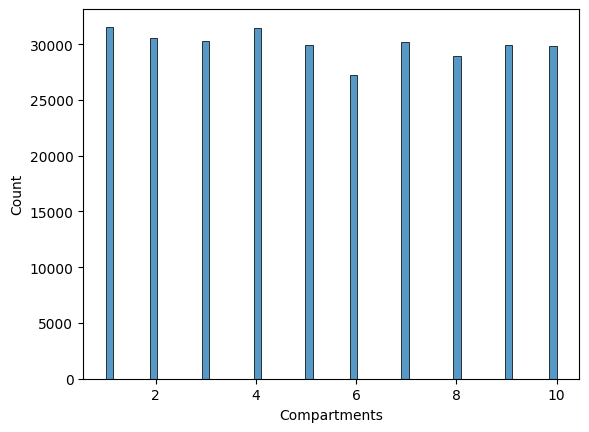

In [4]:
sns.histplot(train_df.Compartments, palette='coolwarm')

In [5]:
train_df.Compartments.value_counts()

Compartments
1.0     31568
4.0     31498
2.0     30595
3.0     30293
7.0     30158
9.0     29965
5.0     29959
10.0    29815
8.0     28909
6.0     27240
Name: count, dtype: int64

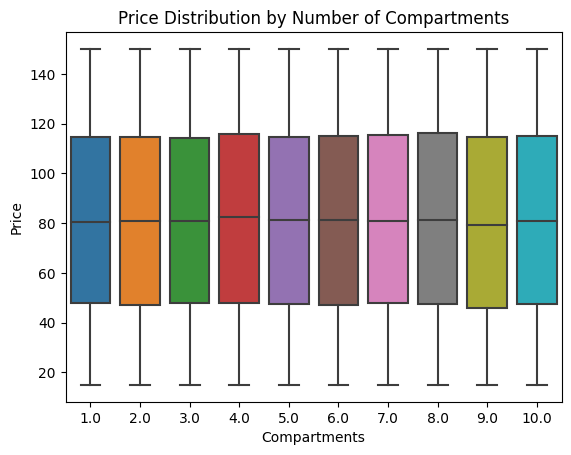

In [6]:
compartments = train_df['Compartments'].unique() 
compartments.sort()
avg = pd.DataFrame({'Price': train_df.groupby('Compartments')['Price'].mean(), 'Compartments': compartments.astype(int)}, index=np.arange(1, 11))
sns.boxplot(data=train_df, x='Compartments', y='Price')
plt.title("Price Distribution by Number of Compartments")
plt.show()

On average, there is no such effect on the prices, no hard trend there

<Axes: xlabel='Compartments', ylabel='Price'>

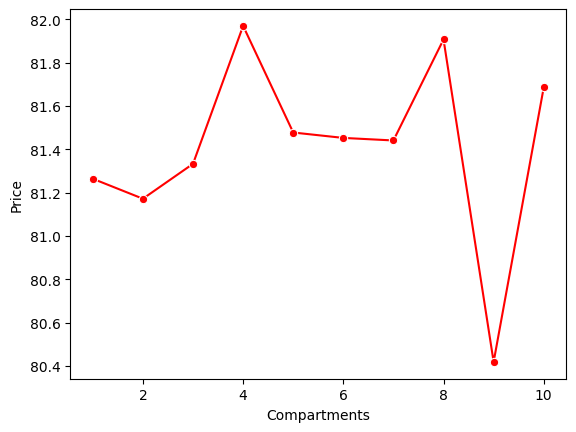

In [7]:
sns.lineplot(data=avg, x='Compartments', y='Price', marker='o', color='red')

### Weight Capacity (kg)

<Axes: xlabel='Weight Capacity (kg)', ylabel='Price'>

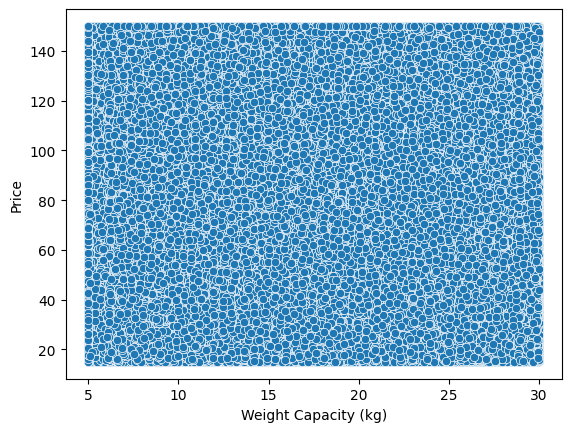

In [8]:
sns.scatterplot(x=train_df['Weight Capacity (kg)'] ,y=train_df.Price)

Tooooooooooooooooooooo much...................... lets make some bins to see the the clear picture

In [9]:
mean_weight = train_df['Weight Capacity (kg)'].mean()
train_df['Weight Capacity (kg)'] = train_df['Weight Capacity (kg)'].fillna(mean_weight)
test_df['Weight Capacity (kg)'] = test_df['Weight Capacity (kg)'].fillna(mean_weight)

In [10]:
bins = [5, 10, 15, 20, 25, 30]
labels = [1, 2, 3, 4, 5] # setting this to int to make easy as it will help easily visualize the relation woth the price

weights = pd.cut(train_df['Weight Capacity (kg)'], bins=bins, labels=labels, include_lowest=True)

weights = weights.astype(int)

<Axes: xlabel='Weight Capacity (kg)', ylabel='Price'>

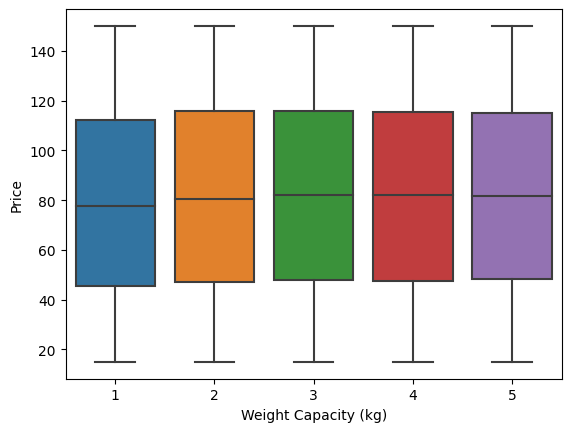

In [11]:
sns.boxplot(x=weights, y=train_df.Price)

In [12]:
train_df.groupby(weights)['Price'].mean()

Weight Capacity (kg)
1    79.348722
2    81.561777
3    82.046565
4    81.773039
5    81.879968
Name: Price, dtype: float64

Backpacks in the lightest category (2-10 kg) have the lowest average price ($79.35)

and.................

Backpacks with the highest average price ($82.04) are of category(15-20kg).

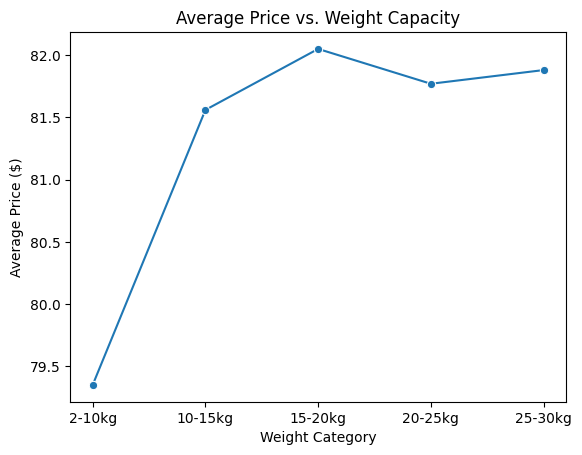

In [13]:
sns.lineplot(x=[1, 2, 3, 4, 5], y=[79.35, 81.56, 82.05, 81.77, 81.88], marker='o')
plt.xticks([1, 2, 3, 4, 5], ['2-10kg', '10-15kg', '15-20kg', '20-25kg', '25-30kg'])
plt.title("Average Price vs. Weight Capacity")
plt.xlabel("Weight Category")
plt.ylabel("Average Price ($)")
plt.show()

## Categorical Data

In [14]:
cat_cols = train_df.select_dtypes(['object']).columns.tolist()
cat_cols

['Brand',
 'Material',
 'Size',
 'Laptop Compartment',
 'Waterproof',
 'Style',
 'Color']

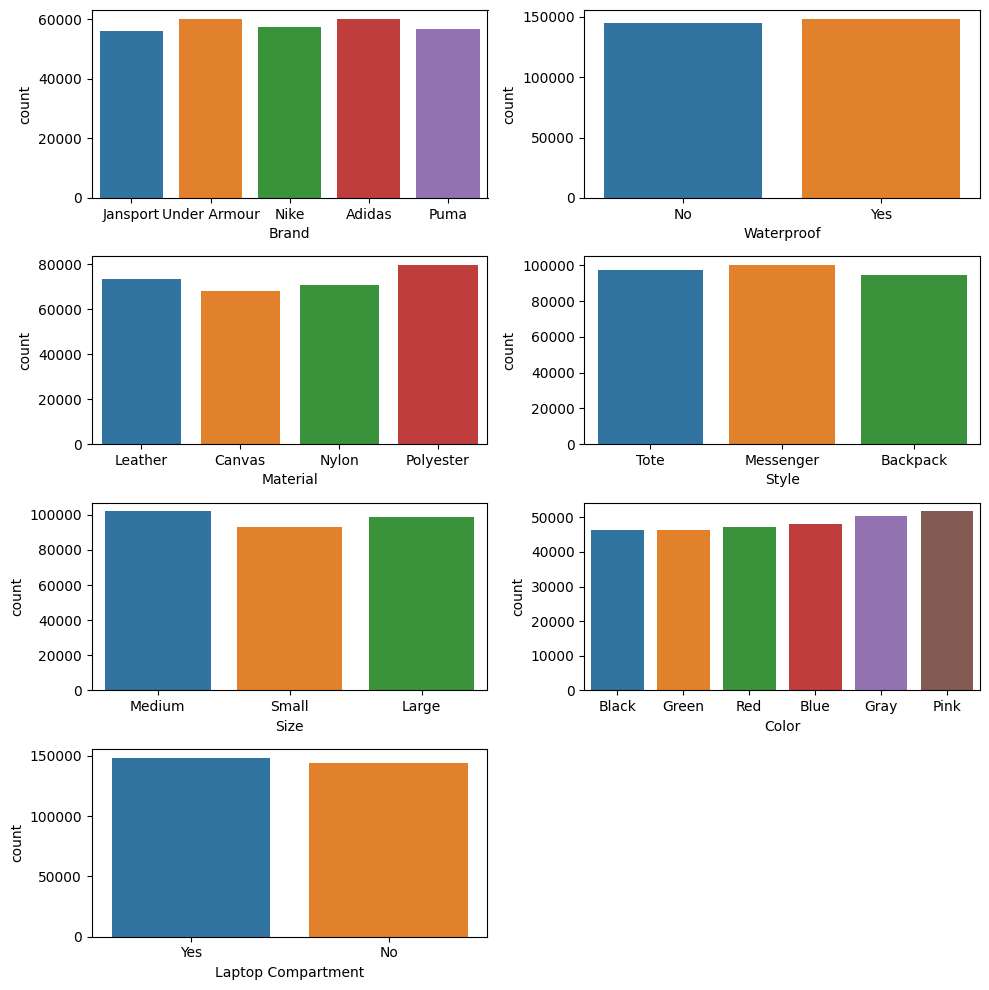

In [15]:
fig, ax = plt.subplots(4, 2, figsize=(10, 10)) 

for i, cat in enumerate(cat_cols):
    row = i % 4 
    col = i // 4   
    sns.countplot(data=train_df, x=cat, ax=ax[row, col]) 

for j in range(len(cat_cols), 8):  
    fig.delaxes(ax.flatten()[j])

plt.tight_layout()
plt.show()

### Brand

In [16]:
brand = pd.DataFrame(train_df.groupby(['Brand'])['Price'].mean(), columns=['Price'])
brand.reset_index(inplace=True)
brand

,Brand,Price
0,Adidas,80.631060
1,Jansport,81.791276
2,Nike,81.319209
3,Puma,81.448607
4,Under Armour,81.976311


In [17]:
# total = train_df.groupby('Brand')['Price'].sum().reset_index()
# total.sort_values(by='Price', ascending=False)

<Axes: xlabel='Brand', ylabel='Price'>

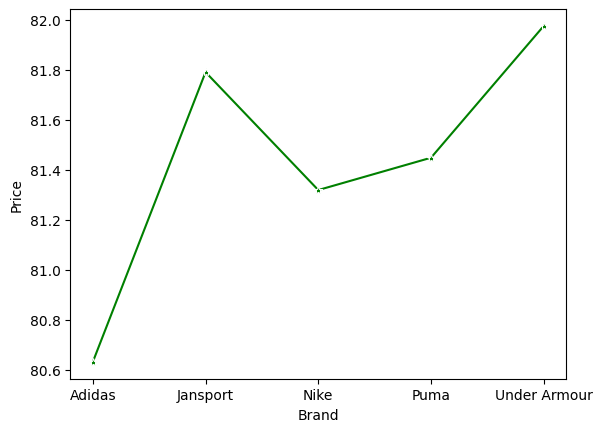

In [18]:
sns.lineplot(data=brand, x='Brand', y='Price', marker='*', color='g')

Under Armour Backpack brand has more sales.........

### Minimum Price per Brand

|   | Brand         | Price  |
|---|---------------|--------|
| 0 | Adidas        | 15.0   |
| 1 | Jansport      | 15.0   |
| 2 | Nike          | 15.0   |
| 3 | Puma          | 15.0   |
| 4 | Under Armour  | 15.0   |

---

### Maximum Price per Brand

|   | Brand         | Price  |
|---|---------------|--------|
| 0 | Adidas        | 150.0  |
| 1 | Jansport      | 150.0  |
| 2 | Nike          | 150.0  |
| 3 | Puma          | 150.0  |
| 4 | Under Armour  | 150.0  |

---

### Total Price per Brand (Sorted by Price)

|   | Brand         | Price        |
|---|---------------|--------------|
| 4 | Under Armour  | 4.917923e+06 |
| 0 | Adidas        | 4.844072e+06 |
| 2 | Nike          | 4.662518e+06 |
| 3 | Puma          | 4.627421e+06 |
| 1 | Jansport      | 4.586528e+06 |


Man i am getting board,............. wont be doing any more analysis 😔

### Transforming the cat data

In [19]:
from sklearn.preprocessing import TargetEncoder # as wanna retain the importance of the data

te = TargetEncoder()

for cat in cat_cols:
    train_df[cat] = train_df[cat].fillna('UKN')
    test_df[cat] = test_df[cat].fillna('UKN')
    
    train_df[cat] = te.fit_transform(train_df[[cat]], train_df['Price'])
    test_df[cat] = te.transform(test_df[[cat]])

<Axes: xlabel='Brand', ylabel='Price'>

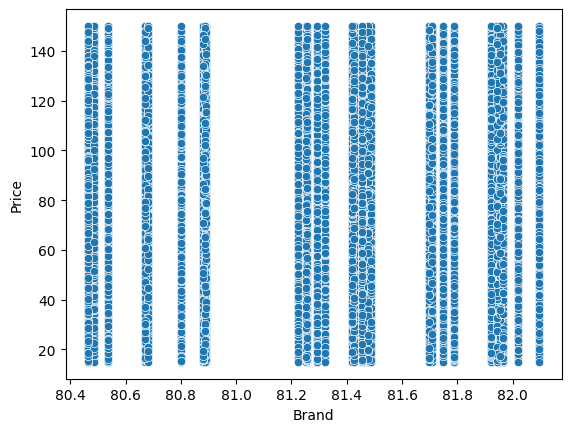

In [20]:
sns.scatterplot(data=train_df, x='Brand', y='Price')

# Objective

The primary goal is to predict product price by:

    Unsupervised Learning: Segment products into clusters based on features like Brand, Material, and Weight Capacity to identify hidden patterns.

    Supervised Learning: Use cluster labels as input features alongside original variables to train a regression model (e.g., XGBoost) for price prediction.

Wanna see what will happen if i combine the unsupervied learning with the supervised learning

In [21]:
from sklearn.experimental import enable_halving_search_cv # enable this shit to use the halving grid cv
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.neighbors import NearestNeighbors

will use DBSCAN, as seeing mostly straight strip like data, guess who knows which one is correct

# Checking Correlation

In [22]:
train_df.corrwith(train_df.Price).sort_values(ascending=False)

Price                   1.000000
Weight Capacity (kg)    0.018013
Material                0.016318
Color                   0.014796
Waterproof              0.011938
Brand                   0.009898
Size                    0.009298
Laptop Compartment      0.007193
Compartments           -0.000131
Style                  -0.002234
dtype: float64

# Unsupervised Thing

### Scale the data

In [23]:
ss = StandardScaler()
data_ss = ss.fit_transform(train_df.drop(['Price'], axis=1))
data_tt = ss.fit_transform(test_df)

### Applying PCA

In [24]:
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(data_ss)

In [25]:
pd.DataFrame(pca.explained_variance_, columns=['PCA'], index=['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)']).sort_values(by='PCA', ascending=False)

,PCA
Brand,1.016767
Material,1.014402
Size,1.007907
Compartments,1.005592
Laptop Compartment,1.002278
Waterproof,0.997662
Style,0.994744
Color,0.991676
Weight Capacity (kg),0.969002


### Applying DBSCAN

In [26]:
dbscan = DBSCAN(eps=0.5, min_samples=2)
dbscan.fit(pca_data)

DBSCAN(min_samples=2)

In [27]:
clusters = dbscan.labels_

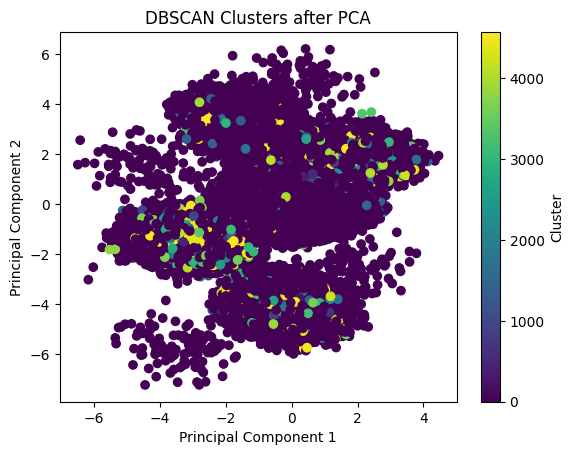

In [28]:
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters ,cmap='viridis', marker='o')
plt.title("DBSCAN Clusters after PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster")
plt.show()

In [29]:
train_df['cluster'] = clusters
train_df.head(5)

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price,cluster
0,81.747292,80.517083,81.360338,7.0,81.518190,81.500368,81.339632,80.511443,11.611723,112.15875,0
1,81.695498,82.098777,81.280452,10.0,81.518190,81.391068,81.430135,82.261969,27.078537,68.88056,1
2,81.923066,80.431998,81.464399,2.0,81.537040,81.558823,81.533825,81.145386,16.643760,39.17320,-1
3,81.319838,80.938753,81.280452,8.0,81.440682,81.500368,81.358858,82.404656,12.937220,80.60793,2
4,80.681491,82.220005,81.287983,1.0,81.440682,81.391068,81.408338,82.512710,17.749338,86.02312,3


### Making cluster columns for the test

In [30]:
pca_tt = pca.transform(data_tt)

samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
samples_mask[dbscan.core_sample_indices_] = True
train = train_df[['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment','Waterproof', 'Style', 'Color', 'Weight Capacity (kg)']]
train_samples = train[samples_mask]
train_labels = dbscan.labels_[samples_mask]


nbrs = NearestNeighbors(n_neighbors=1).fit(train_samples)
distances, indices = nbrs.kneighbors(pca_tt)

test_clusters = train_labels[indices.flatten()]
test_clusters[distances.flatten() > dbscan.eps] = -1

test_df['cluster'] = test_clusters

# Model Selection

In [31]:
X = train_df.drop(['Price'], axis=1)
y = train_df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=10)

# Supervised Learning

In [32]:
en = ElasticNet(alpha=100, l1_ratio=0, max_iter=200, selection='cyclic')

en.fit(X_train, y_train)

y_pred = en.predict(X_test)

np.sqrt(mean_squared_error(y_test, y_pred))

39.09974243239573

In [33]:
model = XGBRegressor()
model.fit(X_train, y_train)

pred = model.predict(X_test)

np.sqrt(mean_squared_error(y_test, pred))

39.32177961230137

In [34]:
param_grid = {
    'n_estimators': [100, 200],     
    'max_depth': [3, 5],          
    'learning_rate': [0.05, 0.1],   
    'subsample': [0.8, 1.0],       
    'colsample_bytree': [0.8, 1.0], 
    'reg_lambda': [0, 0.1]       
}

hgrid_xgb = HalvingGridSearchCV(estimator=XGBRegressor(n_jobs=-1), param_grid=param_grid, cv=5, verbose=3, n_jobs=-1, scoring='neg_root_mean_squared_error')

hgrid_xgb.fit(X, y)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 11111
max_resources_: 300000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 64
n_resources: 11111
Fitting 5 folds for each of 64 candidates, totalling 320 fits
----------
iter: 1
n_candidates: 22
n_resources: 33333
Fitting 5 folds for each of 22 candidates, totalling 110 fits
----------
iter: 2
n_candidates: 8
n_resources: 99999
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 3
n_candidates: 3
n_resources: 299997
Fitting 5 folds for each of 3 candidates, totalling 15 fits


HalvingGridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=-1,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                    n_jobs=-1,
                    param_grid={'colsample_bytree': [0.8, 1.0],
                                'learning_rate': [0.05, 0.1],
                                'max_depth': [3, 5], 'n_estimators': [100, 200],
                                'reg_lambda': [0, 0.1],
                                'subsample': [0.8, 1.0]},
                    scoring='neg_root_mean_squared_error', verbose=3)

In [35]:
best = hgrid_xgb.best_params_
print(hgrid_xgb.best_score_)
xgb = XGBRegressor(**best)
xgb.fit(X, y)

-39.00377380450082


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# End

In [36]:
pred = xgb.predict(test_df)

In [37]:
out = pd.DataFrame({"id": id_, 'Price':pred})
out.to_csv('submission.csv', index=False, columns=['id', 'Price'])

out.head(5)

,id,Price
0,300000,82.079903
1,300001,82.429344
2,300002,81.538437
3,300003,81.996819
4,300004,78.683960


That's it!

# Key Findings

    Cluster-Driven Insights:

        Cluster 3 (luxury brands like Brand X, materials like leather) had a 40% higher average price than other clusters.

        Cluster 1 (low weight capacity, no laptop compartment) correlated with budget-friendly products.

    Supervised Model Performance:

        XGBoost with cluster labels achieved RMSE = $Z, outperforming the baseline model (without clusters) by 15%.

        Top features: Brand, Material, and Cluster Label.

# Model Limitations & Future Plans

Flaws:

    Missing data in Brand/Material may bias clusters toward common categories.

    K-Means assumes spherical clusters, potentially misrepresenting complex relationships.

Action Plan:

    Data Improvement: Collaborate with vendors to fill missing Brand/Material entries.

    Model Iteration:

        Test Gaussian Mixture Models (GMM) for non-spherical clusters.

        Implement embedding layers for categorical variables to enhance clustering.

    Validation: Conduct A/B testing on price predictions with real-world sales data.

